# Section 4

[Link to notebook](https://datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjed-silver%2FDEVP252_Sp24&urlpath=tree%2FDEVP252_Sp24%2FSection4%2FSection4.ipynb&branch=main)

Today will be a review of some R basics that will help you get started on your final projects. 

### Setup

Load packages

In [15]:
pacman::p_load(tidyverse, haven)

Read in data

In [16]:
m_a <- read_dta('Data/009_bihs_r3_male_mod_a.dta') # Main household demographics
m_h1 <- read_dta('Data/021_bihs_r3_male_mod_h1.dta') #Agricultural plot utilization
m_g <- read_dta('Data/020_bihs_r3_male_mod_g.dta') 
m_b1 <- read_dta('Data/010_bihs_r3_male_mod_b1.dta') %>% subset(mem_stat < 7) %>% select(a01, mid, b1_01)

Look at the names of the variables

In [17]:
names(m_a)

[1] "a01"          "stime_h_a"    "stime_m_a"    "res_id_a"     "consent_a"   
 [6] "hh_type"      "a02"          "x1"           "dvcode"       "div"         
[11] "div_name"     "district"     "upazila"      "union"        "mouza"       
[16] "village"      "community_id" "a10"          "a11"          "a12"         
[21] "a13"          "a13oth"       "a14"          "a14oth"       "a15"         
[26] "a15oth"       "a16_1_dd"     "a16_1_mm"     "a16_1_yy"     "a16_2_dd"    
[31] "a16_2_mm"     "a16_2_yy"     "a16_3_dd"     "a16_3_mm"     "a16_3_yy"    
[36] "a16_4_dd"     "a16_4_mm"     "a16_4_yy"     "a16_5_dd"     "a16_5_mm"    
[41] "a16_5_yy"     "a18"          "a19"          "a20_dd"       "a20_mm"      
[46] "a20_yy"       "a21"          "a22"          "a23"          "a24"         
[51] "a25"          "a26"          "a27"          "a27oth"       "etime_h_a"   
[56] "etime_m_a"    "hhid2"        "flag_a"       "round"

In [18]:
head(m_a)

a01,stime_h_a,stime_m_a,res_id_a,consent_a,hh_type,a02,x1,dvcode,div,⋯,a24,a25,a26,a27,a27oth,etime_h_a,etime_m_a,hhid2,flag_a,round
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl+lbl>,<dbl+lbl>
117,8,30,1,1,3,NA,1,10,10,⋯,1,0,1,1,,8,32,117,NA,3
109,7,50,1,1,3,NA,1,10,10,⋯,1,3,1,1,,7,50,109,NA,3
120,7,50,1,1,3,NA,1,10,10,⋯,1,0,1,1,,7,55,120,NA,3
101,8,9,1,1,3,NA,1,10,10,⋯,1,0,1,1,,8,15,101,NA,3
104,8,0,1,1,3,NA,1,10,10,⋯,1,1,1,1,,8,5,104,NA,3
108,8,10,1,1,3,NA,1,10,10,⋯,1,1,1,1,,8,10,108,NA,3


You might prefer to rename variables into something recognizable

In [19]:
# Rename (new_name = old_name)
m_a <- m_a %>% rename(hh_size = a23, hh_sex = a26)

Drop plots with 0 area

In [20]:
m_g <- m_g %>% subset(g02>0)

Create some variables:

Area was measured in decimals (.01 acres) so we want to convert to acres. We then want to calculate rent per acre for plots that were rented.

In [21]:
m_g <- m_g %>% mutate(area = g02/100, rent_pa = g07/area)

Let's also create columns for the number of plots and total area each household has

In [22]:
m_g <- m_g %>% group_by(a01) %>% mutate(num_plots = n(), tot_area = sum(area)) %>% ungroup()

Now plot the data 

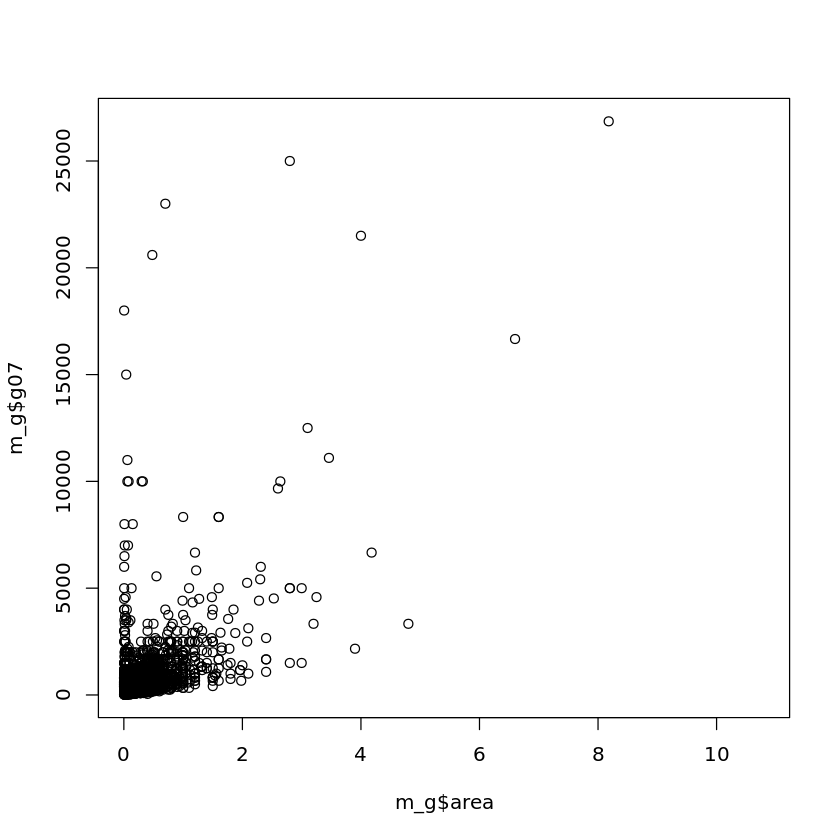

In [23]:
plot(m_g$area,m_g$g07)


### Outlier management

It's very clear we have some outliers in rents, which may be coming from mismeasurement of area or amount paid `g07`. Let's look at the biggest outliers by sorting the data (in descending order) and looking at the first few observations of the relevant variables.

In [24]:
m_g %>% arrange(desc(rent_pa)) %>% head(10) %>% select(area, g07, rent_pa)

area,g07,rent_pa
<dbl>,<dbl>,<dbl>
0.005,18000,3600000
0.005,6000,1200000
0.005,5000,1000000
0.005,4500,900000
0.005,4000,800000
0.010,8000,800000
0.005,4000,800000
0.010,6500,650000
0.005,3000,600000


It seems like the rents are reasonable amounts (\$1 is about 100 Tk) but the areas are tiny and as a result the rents per acre blow up. There are a few ways to proceed from here.

- We could assume something about the nature of the errors. It seems plausible, for example, that enumerators entered acres instead of decimals in these cases. In this case, we'd want to replace impossibly small areas by multiplying them by 100.

- We could also winsorize the data, which means replacing everything above the xth percentile with the value of the xth percentile (and vice versa for below)

- Or we could ignore the outliers altogether

In [25]:
# Create three new columns for area
pacman::p_load(DescTools)

# Create new area variables for each method
m_g <- m_g %>%  mutate(area1 = ifelse(area<.01, area*100, area),
                        area2 = Winsorize(area, probs = c(.025,.975)),
                       area3 = ifelse(area<.01, NA, area ))

#Update create new corresponding rents

m_g <- m_g %>% mutate(rent1 = g07/area1,
                      rent2 = g07/area2,
                      rent3 = g07/area3)

summary(m_g$area1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0100  0.0600  0.1400  0.2252  0.3000 10.8000 

In [26]:
summary(m_g$rent1)


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
    60.1   1041.2   1921.1   6047.0   3333.3 800000.0    19628 

### Merging

Merge demographics into plot data. We want district, household size, and whether the main decision maker is male or female. We also only care about agricultural plots, indicated by `g14` taking a value of 1. Note how we set the `by.x` argument equal to `c('a01','ploti0_h1','round')` and `by.y` argument equal `c('a01','plotid','round')` to which are the variables that we want to merge on. Even though the names of these variables are different, their _values_ are common to both datasets. **Note that these variables should uniquely identify observations in at least one of the dataframes you're merging.** Here `m_g` is at the plot level and `m_h1` is at the plot-season-crop level so we want to test that there are no duplicates in `m_g`. 

In [27]:
# Grouping by HHID and round, count the number of rows in which plotid is duplicated
dupes_g <- m_g %>% group_by(a01,round) %>% filter(duplicated(plotid)) %>% nrow()
# Assert that it's equal to 0. If there's no error message then the statement is true
stopifnot(dupes_g == 0)


So the merge variables uniquely idenitfy rows in `m_g`, meaning we're good to go. 

In [28]:
# Only care about agriclultural plots
df <- merge(m_h1, m_g %>% subset(g14==1), by.x = c('a01','plotid_h1','round'), by.y = c('a01','plotid','round'))

Note that since we there are multiple rows in `m_h1` that correspond to each HH-year-plot observation in `m_g`, R is going to put the information from `m_g` in each of these rows. That means we need to be careful when summing things up, for example. 

Now let's merge some demographic characteristics into the data. 

In [29]:
df <- merge(df, m_a %>% select(a01, district,village, hh_size, hh_sex), by = 'a01', all.x = T)

The only new thing to note here is the `all.x` option, which we've set equal to TRUE. This says that we want to keep all the rows in the first dataframe (`df`), even if we can't match them to the second dataframe (`m_a`). Note that the default is FALSE, meaning that R drops rows it can't match.

### Data manipulation

#### Recoding

The code below collapses the hundreds of diffferent values for different crops into a few broad categories

In [30]:
breaks <- c(0,20,40,50,60,70,80,300,400,412,800)
codes <- seq(10)
labels <- c('Rice','Other grains', 'Fiber crops', 'Pulses', 'Oilseeds', 'Spices','Vegetables', 'Fruit', 'Potato','Other Crops')
df$crop_a <- cut(df$crop_a_h1, breaks, codes, include.lowest = F, include.highest = T) %>% factor(labels=labels)

Let's look at average plot areas by crop

In [31]:
df %>% group_by(crop_a) %>% summarize(mean(area))

crop_a,mean(area)
<fct>,<dbl>
Rice,0.3034522
Other grains,0.2723065
Fiber crops,0.2507233
Pulses,0.3049158
Oilseeds,0.2908430
Spices,0.2063303
Vegetables,0.1778025
Fruit,0.4044286
Potato,0.2362434


In [32]:
df2 <- df %>% merge(m_b1, by.x = c('a01','g15a'), by.y = c('a01','mid'), all.x = T)

In [33]:
df2 <- df2 %>% group_by(a01) %>% mutate(both = min(b1_01,na.rm = T)<max(b1_01,na.rm=T)) %>% ungroup()

### Regressions

In [34]:
pacman::p_load(lfe)

Use `felm` from the `lfe` package to estimate regressions. `stargazer` is a nice package to make regression tables, but it doesn't play nice with Jupyter. The four arguments in order are the 1) formula 2) fixed-effects (don't worry about this if you're not familiar with them - put 0 if you don't want to use them) 3) instruments (also set to 0 unless you are using them) and 4) cluster variable. 

In [35]:
felm(rent1~crop_a|district|0|district, data = df) %>% summary()


Call:
   felm(formula = rent1 ~ crop_a | district | 0 | district, data = df) 

Residuals:
    Min      1Q  Median      3Q     Max 
-3413.8  -454.7   -60.9   383.9  4174.1 

Coefficients:
                   Estimate Cluster s.e. t value Pr(>|t|)   
crop_aOther grains  -116.43       127.57  -0.913  0.36510   
crop_aFiber crops     28.60       137.63   0.208  0.83607   
crop_aPulses         -39.32       108.72  -0.362  0.71892   
crop_aOilseeds      -189.97       128.94  -1.473  0.14596   
crop_aSpices         353.67       232.79   1.519  0.13404   
crop_aVegetables     319.51       104.21   3.066  0.00327 **
crop_aFruit          236.66       381.05   0.621  0.53694   
crop_aPotato         126.59       131.76   0.961  0.34061   
crop_aOther Crops    709.64       223.39   3.177  0.00237 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 794.8 on 1652 degrees of freedom
  (12592 observations deleted due to missingness)
Multiple R-squared(full mo

Taking logs of the dependent variable (interpret coefficients as a percent difference. Also more robust to outliers)

In [36]:
felm(log(rent1)~crop_a|district|0|district, data = df) %>% summary()


Call:
   felm(formula = log(rent1) ~ crop_a | district | 0 | district,      data = df) 

Residuals:
     Min       1Q   Median       3Q      Max 
-2.18496 -0.25188  0.03728  0.26286  1.59609 

Coefficients:
                   Estimate Cluster s.e. t value Pr(>|t|)   
crop_aOther grains -0.08662      0.09538  -0.908  0.36750   
crop_aFiber crops   0.03251      0.06421   0.506  0.61449   
crop_aPulses       -0.02362      0.07083  -0.333  0.74000   
crop_aOilseeds     -0.17907      0.11383  -1.573  0.12104   
crop_aSpices        0.18507      0.13599   1.361  0.17871   
crop_aVegetables    0.21823      0.06521   3.347  0.00143 **
crop_aFruit         0.15601      0.14014   1.113  0.27013   
crop_aPotato        0.01939      0.07850   0.247  0.80579   
crop_aOther Crops   0.33105      0.10734   3.084  0.00311 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4806 on 1652 degrees of freedom
  (12592 observations deleted due to missingness)
Multi

### More R resources

- [R for Data Science](https://r4ds.had.co.nz/): A comprehensive guide to using R written by Hadley Wickham (the godfather of R)
- [The R Cookbook](https://rc2e.com/): A similarly comprehensive guide
- [Cheat Sheet for Base R](https://iqss.github.io/dss-workshops/R/Rintro/base-r-cheat-sheet.pdf): i.e. not fancy packages
- [Tidyverse Cheat Sheet](https://www.rstudio.com/wp-content/uploads/2015/02/data-wrangling-cheatsheet.pdf): Much of what we've been doing